## Importing Libraries

In [93]:
data_folder = r"C:\Users\likhi\Documents\02 Pycharm Datasets\01 Master Thesis\04 Product Data"
question_data_folder = r"C:\Users\likhi\Documents\02 Pycharm Datasets\01 Master Thesis\07 QnA\QnA Limit 100"

destination_image_dir = r'C:\Users\likhi\Documents\02 Pycharm Datasets\01 Master Thesis\09 Visual QnA\dataset - version 1'

In [160]:
import os
import json
import pandas as pd
from tqdm import tqdm
import shutil
from utils.Amazon_captcha_solver_v2 import custom_Amazon_captcha_solver
import re
import time
import random

import warnings
warnings.filterwarnings("ignore")

import torch
from typing import List, Union
from dataclasses import dataclass

from transformers import (
    # Preprocessing / Common
    AutoTokenizer, AutoFeatureExtractor,
    # Text & Image Models (Now, image transformers like ViTModel, DeiTModel, BEiT can also be loaded using AutoModel)
    AutoModel,            
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging
)

In [108]:
category_limit_counter = 100
max_retry_limit = 2

image_pattern = re.compile("( (in |on |of )?(the |this )?(image\d*) \?)")                

## Setting up scrapper for QnA data

In [97]:
import bezier
import pyautogui
import numpy as np

def resting_mouse(driver):
    """move mouse to right of screen."""

    panelWidht = driver.execute_script('return window.outerWidth;')
    start = pyautogui.position()
    end = random.randint(panelWidht - 100, panelWidht), random.randint(400, 850)

    x2 = (start[0] + end[0]) / 2  # midpoint x
    y2 = (start[1] + end[1]) / 2  ##midpoint y

    control1X = (start[0] + x2) / 2
    control2X = (end[0] + x2) / 2

    # Two intermediate control points that may be adjusted to modify the curve.
    control1 = control1X, y2  ##combine midpoints to create perfect curve
    control2 = control2X, y2  ## using y2 for both to get a more linear curve

    # Format points to use with bezier
    control_points = np.array([start, control1, control2, end])
    points = np.array([control_points[:, 0], control_points[:, 1]])  # Split x and y coordinates
    # You can set the degree of the curve here, should be less than # of control points
    degree = 3
    # Create the bezier curve
    curve = bezier.Curve(points, degree)

    curve_steps = 70  # How many points the curve should be split into. Each is a separate pyautogui.moveTo() execution
    delay = 0.008  # Time between movements. 1/curve_steps = 1 second for entire curve

    # Move the mouse
    for j in range(1, curve_steps + 1):
        # The evaluate method takes a float from [0.0, 1.0] and returns the coordinates at that point in the curve
        # Another way of thinking about it is that i/steps gets the coordinates at (100*i/steps) percent into the curve
        x, y = curve.evaluate(j / curve_steps)
        pyautogui.moveTo(x, y)  # Move to point in curve
        pyautogui.sleep(delay)  # Wait delay
    time.sleep(2)


In [98]:
from selenium import webdriver
from selenium.webdriver.common.by import By

import warnings
warnings.filterwarnings("ignore")

base_url = "https://www.amazon.com/ask/questions/asin/"
options = webdriver.ChromeOptions()
# options.add_argument('--headless')
options.add_argument("--incognito")
options.add_argument('--disable-blink-features=AutomationControlled')

def website_setup():

    driver = webdriver.Chrome(options=options)

    ## Testing with Amazon Home Page URL to enter CAPTCHA to avoid looking like a robot

    custom_Amazon_captcha_solver(driver, driver_close=False)

    try:
        driver.maximize_window()
    except:
        pass
 
    return driver

def notebook_qna_extractor(product_asin, driver):

    url = base_url + product_asin

    driver.get(url)

    num_of_qna = len(driver.find_elements(By.XPATH, '//*[@class="a-section askTeaserQuestions"]/div'))

    if num_of_qna > 0:

        try:
            # Find all question-answer pairs
            question_answer_pairs = []

            for qa_div in range(num_of_qna):
                question = driver.find_element(By.XPATH, '//*[@class="a-section askTeaserQuestions"]/div[' + str(
                    qa_div + 1) + ']/div/div[2]/div[1]/div/div[2]/a/span').text
                answer = driver.find_element(By.XPATH,
                                             '//*[@class="a-section askTeaserQuestions"]/div[' + str(
                                                 qa_div + 1) + ']/div/div[2]/div[2]/div/div[2]/span[1]').text
                question_answer_pairs.append([question, answer])

            return question_answer_pairs

        except:

            pass
    
    driver.execute_script("window.scrollBy(0, 500);")
    resting_mouse(driver)
    
    driver.close()

## Extracting data - with FAQ data

In [ ]:
categories = os.listdir(data_folder)

training_df = pd.DataFrame({"question": [], "answer": [], "image_id":[]})

for category in tqdm(categories):
    
    print(category)
    driver = website_setup()
    category_counter = 0
    retry_count = 0
    
    qna_file_path = os.path.join(question_data_folder, category + "_Amazon QnA_data.json")
    products_list = os.listdir(os.path.join(data_folder, category))
    
    random.shuffle(products_list)
    
    qna_data = json.load(open(qna_file_path, 'r', encoding='utf-8'))
    for product in tqdm(products_list):
        asin = product.strip().split('_')[-1]
  
        images = [i for i in os.listdir(os.path.join(data_folder, category, product)) if '.jpg' in i]
        
        if len(images) > 0:
            
            data = json.load(open(os.path.join(data_folder, category, product, product + ".json"), "r", 
                                  encoding="utf-8"))
            product_overview = data.get('product_overview', '')
            product_overview_text = ". ".join([key + " is " + value 
                                                                for key, value in product_overview.items() 
                                                                ])
          
            product_overview_qna = [ ["What is the " + key + " of the product?", 
                                       value + " is the " + key +" of the product."] 
                                      for key, value in product_overview.items()]
            
            try:
                qna_data = notebook_qna_extractor(asin, driver)
                
                if qna_data is not None and len(qna_data) > 0:
                    total_qna = product_overview_qna + qna_data
                elif product_overview_qna is not None and len(product_overview_qna) > 0:
                    total_qna = product_overview_qna
                else:
                    total_qna = []
                    
                if total_qna != []:
                    
                    for image in images:
                        
                        for qna_pair in total_qna:
                            question = qna_pair[0]
                            answer = qna_pair[1]
                            
                            record = pd.DataFrame([{
                                    "question": question,
                                    "answer": answer,
                                    "image_id": image,
                                    }])
                            training_df = pd.concat([training_df, record], axis=0)
                            
                            shutil.copy(os.path.join(data_folder, category, product, image),
                                        os.path.join(destination_image_dir, image))
                            
                            category_counter += 1
                   
                        if category_counter >= category_limit_counter:
                            break
                time.sleep(3)
                 
            except Exception as e:
                print(e)
                retry_count += 1
                if retry_count <= max_retry_limit:
                    driver = website_setup()
                else:
                    print(len(training_df))
                    break
                       

## Extracting Data - without FAQ data 

In [192]:
categories = os.listdir(data_folder)

training_df = pd.DataFrame({"question": [], "answer": [], "image_id":[]})

for category in tqdm(categories):
    
    category_counter = 0
    retry_count = 0
    
    qna_file_path = os.path.join(question_data_folder, category + "_Amazon QnA_data.json")
    products_list = os.listdir(os.path.join(data_folder, category))
    
    random.shuffle(products_list)
    
    qna_data = json.load(open(qna_file_path, 'r', encoding='utf-8'))
    for product in products_list:
        asin = product.strip().split('_')[-1]
  
        images = [i for i in os.listdir(os.path.join(data_folder, category, product)) if '.jpg' in i]
        
        if len(images) > 0:
            
            data = json.load(open(os.path.join(data_folder, category, product, product + ".json"), "r", 
                                  encoding="utf-8"))
            product_overview = data.get('product_overview', '')
            product_overview_text = ". ".join([key + " is " + value 
                                                                for key, value in product_overview.items() 
                                                                ])
          
            product_overview_qna = [ ["What is the " + key + " of the product?", 
                                       value + " is the " + key +" of the product."] 
                                      for key, value in product_overview.items()]
        
            if product_overview_qna:
                
                for image in images:
                    
                    for qna_pair in product_overview_qna:
                        
                        question = qna_pair[0].encode('ascii', 'ignore').decode('ascii', 'ignore')
                        answer = qna_pair[1].encode('ascii', 'ignore').decode('ascii', 'ignore')
                        
                        if len(answer.strip().split(" ")) >= 2:
                        
                            record = pd.DataFrame([{
                                    "question": question,
                                    "answer": answer,
                                    "image_id": image,
                                    }])
                            training_df = pd.concat([training_df, record], axis=0)
                            
                            
                            shutil.copy(os.path.join(data_folder, category, product, image),
                                        os.path.join(destination_image_dir, image))
                            
                            category_counter += 1
                            
                            if category_counter >= category_limit_counter:
                                break   
                                
                    if category_counter >= category_limit_counter:
                            break   
                        
        if category_counter >= category_limit_counter:
            break   

100%|██████████| 265/265 [02:43<00:00,  1.62it/s]


In [193]:
training_df.to_csv(os.path.join(os.path.dirname(destination_image_dir),
                                "data_train - version 1.csv"), index=None)

In [194]:
print(len(training_df))

21637


## Creating a list of all possible answers

In [195]:
answer_space = []
for ans in training_df.answer.to_list():
    answer_space = answer_space + [ans] 

answer_space = list(set(answer_space))
answer_space.sort()
with open(os.path.join(os.path.dirname(destination_image_dir), "answer_space - version 1.txt"),
          "w", encoding="utf-8") as f:
    f.writelines("\n".join(answer_space))

## Loading the data

In [196]:
# Load the training & evaluation dataset present in CSV format
from datasets import load_dataset

dataset = load_dataset(
    "csv", 
    data_files={
        "train": os.path.join(os.path.dirname(destination_image_dir), "data_train - version 1.csv"),
    }
)

# Load the space of all possible answers
with open(os.path.join(os.path.dirname(destination_image_dir), 
                       "answer_space - version 1.txt")) as f:
    answer_space = f.read().splitlines()

# Since we model the VQA task as a multiclass classification problem,
# we need to create the labels from the actual answers
dataset = dataset.map(
    lambda examples: {
        'label': [
            # Select the 1st answer if multiple answers are provided for single question
            answer_space.index(ans)
            for ans in examples['answer']
        ]
    },
    batched=True
)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/21637 [00:00<?, ? examples/s]

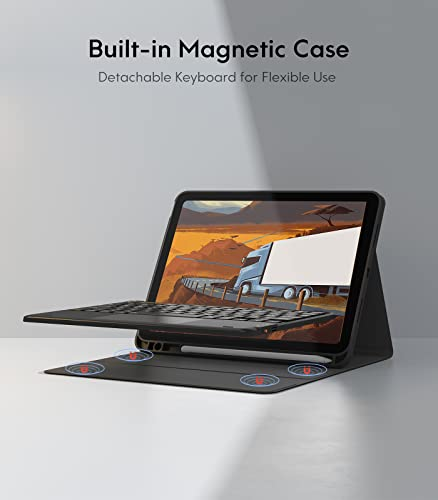

Question:	 What is the Special Feature of the product?
Answer:		 Backlit, Trackpad is the Special Feature of the product. (Label: 1058)


In [197]:
from IPython.display import display
from PIL import Image

def showExample( id=None):
    data = dataset["train"]
    if id == None:
        id = np.random.randint(len(data))
    image = Image.open(os.path.join(destination_image_dir, data[id]["image_id"] ))
    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id]["label"]))
    
showExample()

### Defining Multimodal dataset

In [198]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 21637
    })
})

In [209]:
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=64,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'],
            "token_type_ids": encoded_text['token_type_ids'],
            "attention_mask": encoded_text['attention_mask'],
        }

    def preprocess_images(self, images: List[str]):
        processed_images = self.preprocessor(
            images=[Image.open(os.path.join(destination_image_dir, image_id)).convert('RGB') 
                    for image_id in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'],
        }
            
    def __call__(self, raw_batch_dict):
        raw_batch_dict = [raw_batch_dict]
        questions = [instance['question'] for instance in raw_batch_dict]
        image_ids = [instance['image_id'] for instance in raw_batch_dict]
        labels = [instance['label'] for instance in raw_batch_dict]

        tokenized_text = self.tokenize_text(questions)
        processed_images = self.preprocess_images(image_ids)

        return {
            **tokenized_text,
            **processed_images,
            'labels': torch.tensor(labels, dtype=torch.int64),
        }

In [210]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
preprocessor = AutoFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

multimodal_collator = MultimodalCollator(tokenizer=tokenizer, preprocessor=preprocessor)

In [211]:
# Preprocess the dataset using the collator
preprocessed_dataset = dataset.map(multimodal_collator)

Map:   0%|          | 0/21637 [00:00<?, ? examples/s]

In [212]:
preprocessed_dataset.save_to_disk(os.path.join(os.path.dirname(destination_image_dir), 'training_dataset - version_1'))

Saving the dataset (0/27 shards):   0%|          | 0/21637 [00:00<?, ? examples/s]

In [213]:
preprocessed_dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'labels'],
        num_rows: 21637
    })
})